<h1 align="center">All relevant feature selection</h1>
<h2 align="center"> pre-filters </h2>
<p style="text-align:center">
   Human Bender<br>
</p>

<div align="center">
    <img border="0" src="bender_hex_mini.png" width="100px" align="center" />
</div>


<h2 style="color:#deab02;">Introduction</h2>

Before performing All Relevant Feature Selection, you might want to apply pre-filters to remove columns:

 - a lot of missing values
 - zero variance
 - high cardinality
 - highly correlated (and keep only one)
 - zero predictive power
 - low predictive power

Any of those steps can be ignored.


<h2 style="color:#deab02;">1 - Configuration, Loading the packages, data and utilities definition </h2>
 

First let's set the libraries, general settings and define some functions (in the notebook for convenience, will be moved in a library during a later stage).

## Packages

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

In [11]:
# Settings and libraries
from __future__ import print_function

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import arfs.featselect as arfsfs
import arfs.allrelevant as arfsgroot

%matplotlib inline

<h2 style="color:#deab02;"> Generating artificial data </h2>

Inspired by the BorutaPy unit test

In [6]:
def _generated_corr_dataset_regr():
    # weights
    w = np.random.beta(a=1, b=0.5, size=1000)
    # fixing the seed and the target
    np.random.seed(42)
    sigma = 0.2
    y = np.random.normal(1, sigma, 1000)
    z = y - np.random.normal(1, sigma / 5, 1000) + np.random.normal(1, sigma / 5, 1000)
    X = np.zeros((1000, 13))

    # 5 relevant features, with positive and negative correlation to the target
    X[:, 0] = z
    X[:, 1] = y * np.abs(np.random.normal(0, sigma * 2, 1000)) + np.random.normal(0, sigma / 10, 1000)
    X[:, 2] = -y + np.random.normal(0, sigma, 1000)
    X[:, 3] = y ** 2 + np.random.normal(0, sigma, 1000)
    X[:, 4] = np.sqrt(y) + np.random.gamma(1, .2, 1000)

    # 5 irrelevant features
    X[:, 5] = np.random.normal(0, 1, 1000)
    X[:, 6] = np.random.poisson(1, 1000)
    X[:, 7] = np.random.binomial(1, 0.3, 1000)
    X[:, 8] = np.random.normal(0, 1, 1000)
    X[:, 9] = np.random.poisson(1, 1000)
    # zero variance
    X[:, 10] = np.ones(1000)
    # high cardinality
    X[:, 11] = np.arange(start=0, stop=1000, step=1)
    # a lot of missing values
    idx_nan = np.random.choice(1000, 500, replace=False)
    X[:, 12] = y ** 3 + np.abs(np.random.normal(0, 1, 1000))
    X[idx_nan, 12] = np.nan

    # make  it a pandas DF
    column_names = ['var' + str(i) for i in range(13)]
    column_names[11] = 'emb_dummy'
    X = pd.DataFrame(X)
    X.columns = column_names
    X['emb_dummy'] = X['emb_dummy'].astype('category')

    return X, y, w


def _generated_corr_dataset_classification():
    # weights
    w = np.random.beta(a=1, b=0.5, size=1000)
    # fixing the seed and the target
    np.random.seed(42)
    y = np.random.binomial(1, 0.5, 1000)
    X = np.zeros((1000, 13))

    z = y - np.random.binomial(1, 0.1, 1000) + np.random.binomial(1, 0.1, 1000)
    z[z == -1] = 0
    z[z == 2] = 1

    # 5 relevant features, with positive and negative correlation to the target
    X[:, 0] = z
    X[:, 1] = y * np.abs(np.random.normal(0, 1, 1000)) + np.random.normal(0, 0.1, 1000)
    X[:, 2] = -y + np.random.normal(0, 1, 1000)
    X[:, 3] = y ** 2 + np.random.normal(0, 1, 1000)
    X[:, 4] = np.sqrt(y) + np.random.binomial(2, 0.1, 1000)

    # 5 irrelevant features
    X[:, 5] = np.random.normal(0, 1, 1000)
    X[:, 6] = np.random.poisson(1, 1000)
    X[:, 7] = np.random.binomial(1, 0.3, 1000)
    X[:, 8] = np.random.normal(0, 1, 1000)
    X[:, 9] = np.random.poisson(1, 1000)
    # zero variance
    X[:, 10] = np.ones(1000)
    # high cardinality
    X[:, 11] = np.arange(start=0, stop=1000, step=1)
    # a lot of missing values
    idx_nan = np.random.choice(1000, 500, replace=False)
    X[:, 12] = y ** 3 + np.abs(np.random.normal(0, 1, 1000))
    X[idx_nan, 12] = np.nan

    # make  it a pandas DF
    column_names = ['var' + str(i) for i in range(13)]
    column_names[11] = 'emb_dummy'
    X = pd.DataFrame(X)
    X.columns = column_names
    X['emb_dummy'] = X['emb_dummy'].astype('category')

    return X, y, w

In [9]:
X, y, w = _generated_corr_dataset_regr()
data = X.copy()
data['target'] = y

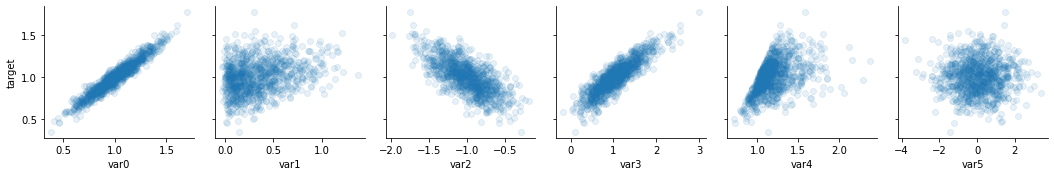

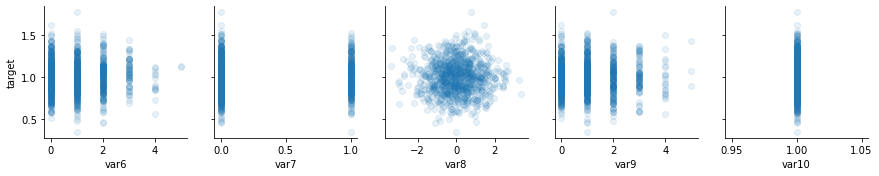

In [12]:
x_vars = ["var0", "var1", "var2", "var3", "var4", "var5"]
y_vars = ["target"]
g = sns.PairGrid(data, x_vars=x_vars, y_vars=y_vars)
g.map(plt.scatter, alpha=0.1)

x_vars = ["var6", "var7", "var8", "var9", "var10"]
y_vars = ["target"]
g = sns.PairGrid(data, x_vars=x_vars, y_vars=y_vars)
g.map(plt.scatter, alpha=0.1)

In [13]:
# X is the predictor DF (e.g: df[predictor_list]), at this stage you don't need to 
# specify the target and weights (only for identifying zero and low importance)
fs = arfsfs.FeatureSelector(data = X, labels = y, weight = w)
# filter out missing and store in dic
fs.identify_missing(missing_threshold=0.2)
fsDic = {}
fsDic['missing'] = fs.ops['missing']
fs.plot_missing()

1 features with greater than 0.20 missing values.



NameError: name 'mpl' is not defined

In [ ]:
# single unique value columns
fs.identify_single_unique()
fsDic['single_unique'] = fs.ops['single_unique']
fs.plot_unique()

In [ ]:
# high cardinality for categoricals predictors
fs.identify_high_cardinality(max_card=2000)
fsDic['high_cardinality'] =  fs.ops['high_cardinality']
fs.plot_cardinality()

In [ ]:
# collect columns to drop and force some predictors
cols_to_drop = fs.check_removal()
filtered_features = list( set(X.columns) - set(cols_to_drop) )
filtered_features = former_pred + sorted(list( set(filtered_features) - set(former_pred) ))
survivors_cols = targets + exposure  + filtered_features
df_red = df[survivors_cols].copy()
# tagging and keeping track of everything
fs_df = fs.tag_df
fs_df

In [3]:
####################################################
#												   #
# Run if you want to remove highly correlated cols #
#												   #
####################################################
gc.enable()
del(fs)
gc.collect()
# New instance of the class
fs = noglmfs.FeatureSelector(data = X[filtered_features], labels = None, weight = None)
# identify highly correlated columns (here corr_coef >= 0.75)
# set encode to True if there are categorical/string cols (takes a bit of time)
fs.identify_collinear(correlation_threshold=0.75, encode=False)
# tag the discarded predictors and store the results
fs_df = fs_df.merge(fs.tag_df, how='left')
fsDic['collinear'] = sorted(fs.ops['collinear'])
# Plot and save the corr-map
heatmap = fs.plot_collinear(plot_all=True, size=1000)
hv.save(heatmap, "C:User/my_folder/heatmap_corr.html")

In [5]:
gc.enable()
gc.collect()

26

<h2 style="color:#deab02;"> Testing and comparing Leshy, GrootCV and BoostAGroota </h2>

In the following examples, I'll use classical data set to which I added random predictors (numerical and categorical). An *All Relveant FS* methods should discard them.
In the unit tests, you'll find examples using artifical data with genuine (correlated and non-linear) predictors and with some random/noise columns.

==================== Benchmarking using sklearn permutation importance ====================


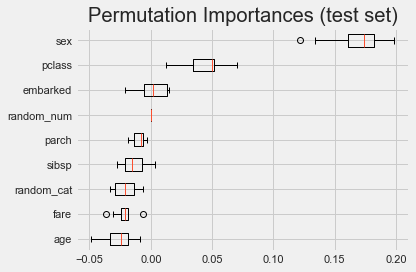

==================== Leshy - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	5
Tentative: 	0
Rejected: 	2
All relevant predictors selected in 00:00:30.95
['pclass', 'sex', 'embarked', 'parch', 'fare']


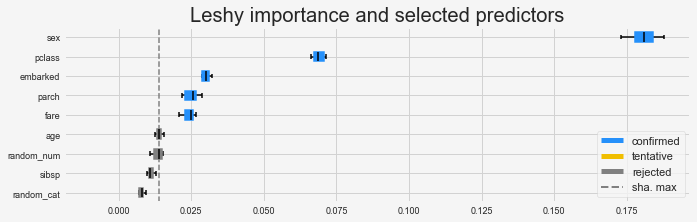

==================== Leshy - testing: <catboost.core.CatBoostClassifier object at 0x0000018F77356A48> for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	5
Tentative: 	0
Rejected: 	3
All relevant predictors selected in 00:00:05.44
['pclass', 'sex', 'embarked', 'parch', 'fare']


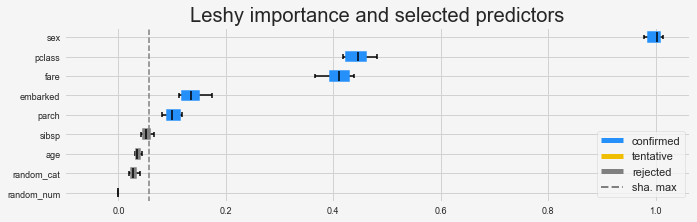

==================== Leshy - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	1
Rejected: 

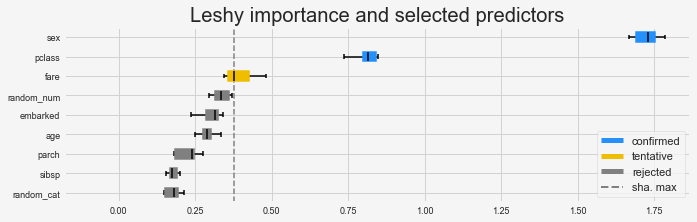

==================== Leshy - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:04.23
['pclass', 'sex']


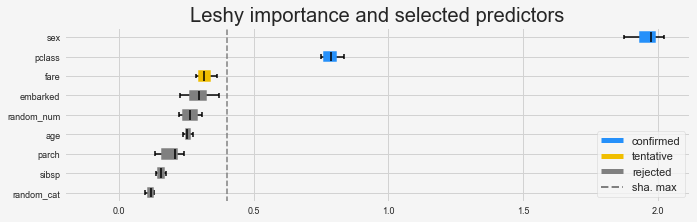

==================== Leshy - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.3333333333333333, force_col_wise=True,
               verbose=-1) for var.imp: shap            ====================
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration: 1 / 10
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 

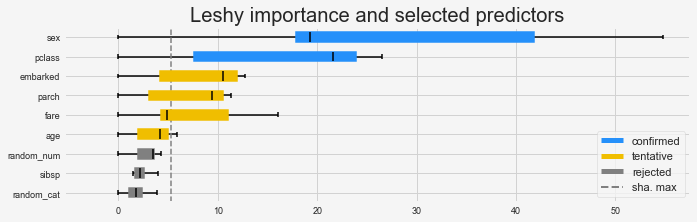

==================== Leshy - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	5
Rejected: 	0
All relevant predictors selected in 00:00:23.70
['pclass', 'sex']


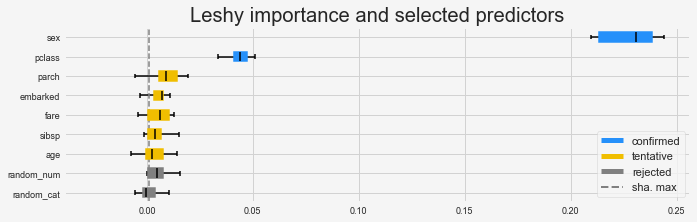

==================== Leshy - testing: <catboost.core.CatBoostClassifier object at 0x0000018F773E7148> for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	2
Rejected: 	1
All relevant predictors selected in 00:00:08.78
['pclass', 'sex', 'fare']


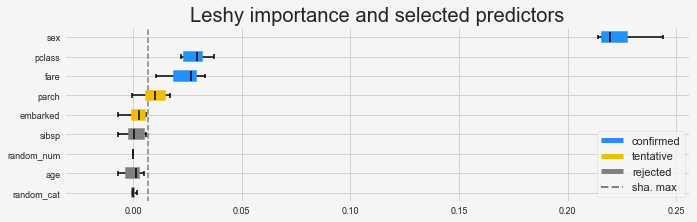

==================== Leshy - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	3
Rejected: 

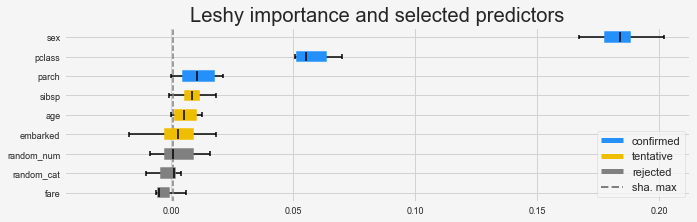

==================== Leshy - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	3
Rejected: 	0
All relevant predictors selected in 00:00:03.36
['pclass', 'sex']


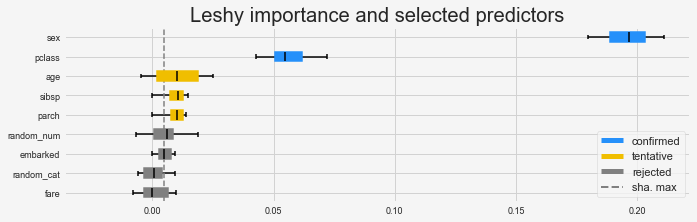

==================== Leshy - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.3333333333333333, force_col_wise=True,
               verbose=-1) for var.imp: pimp            ====================
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration: 1 / 10
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 

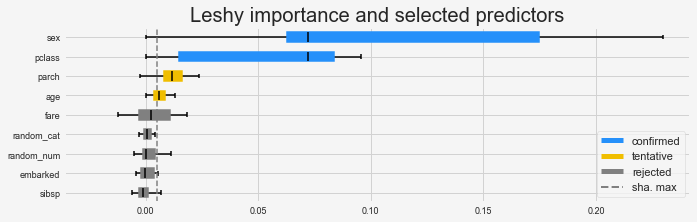

==================== Leshy - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	0
Rejected: 	5
All relevant predictors selected in 00:00:03.59
['sex', 'fare', 'random_num']


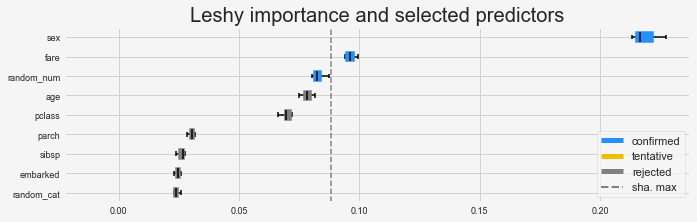

==================== Leshy - testing: <catboost.core.CatBoostClassifier object at 0x0000018F773D1908> for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	3
All relevant predictors selected in 00:00:04.89
['pclass', 'sex', 'parch', 'fare']


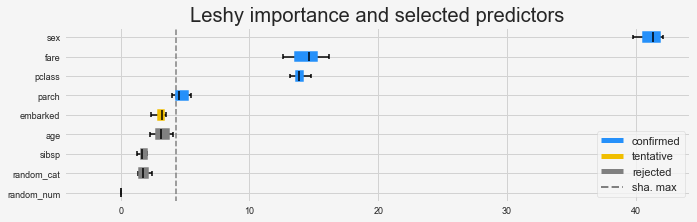

==================== Leshy - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	2
Rejected

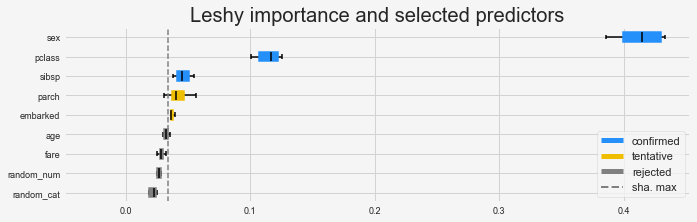

==================== Leshy - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	1
Tentative: 	1
Rejected: 	7
All relevant predictors selected in 00:00:00.74
['random_num']


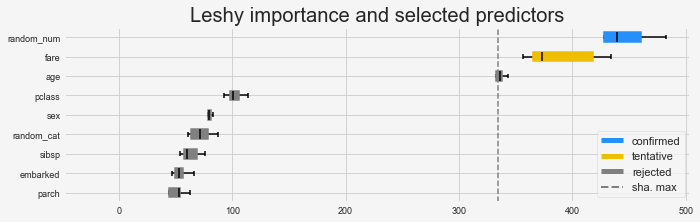

==================== Leshy - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.3333333333333333, force_col_wise=True,
               verbose=-1) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	0
Tentative: 	1
Rejected: 	6
All relevant predictors selected in 00:00:00.53
[]


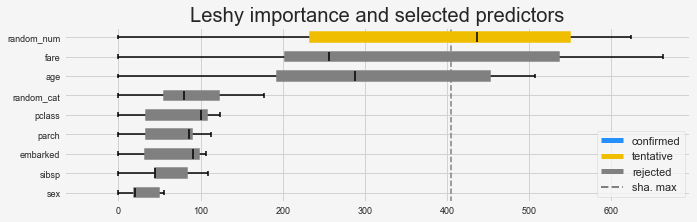

==================== Leshy - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	22
Tentative: 	3
Rejected: 	2
All relevant predictors selected in 00:00:03.23
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'radius error', 'perimeter error', 'area error', 'concavity error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


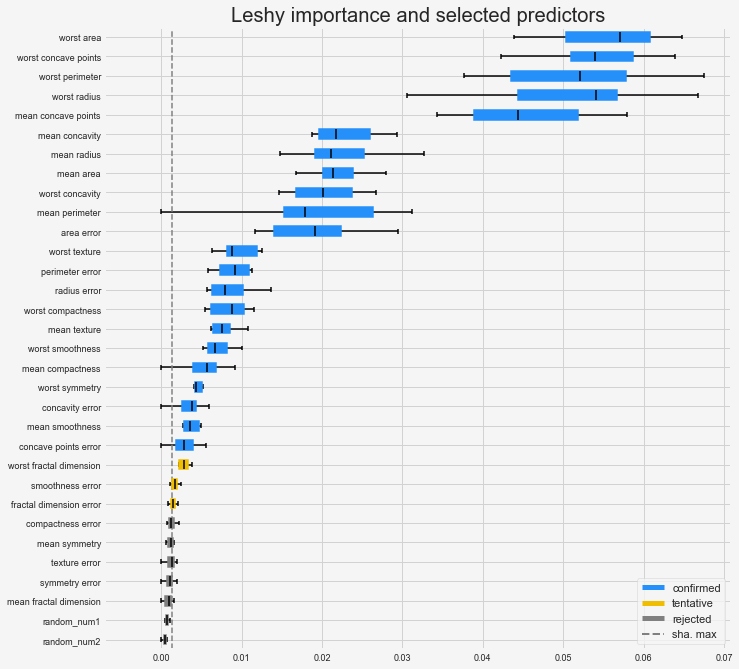

==================== Leshy - testing: <catboost.core.CatBoostClassifier object at 0x0000018F776E86C8> for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	18
Tentative: 	3
Rejected: 	6
All relevant predictors selected in 00:00:07.89
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean concavity', 'mean concave points', 'radius error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry']


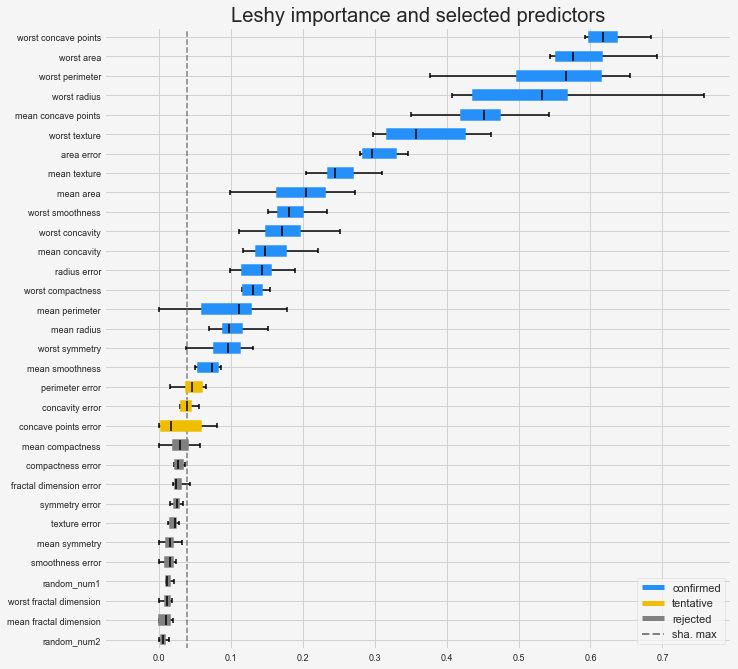

==================== Leshy - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	11
Tentative: 	3
Rejected:

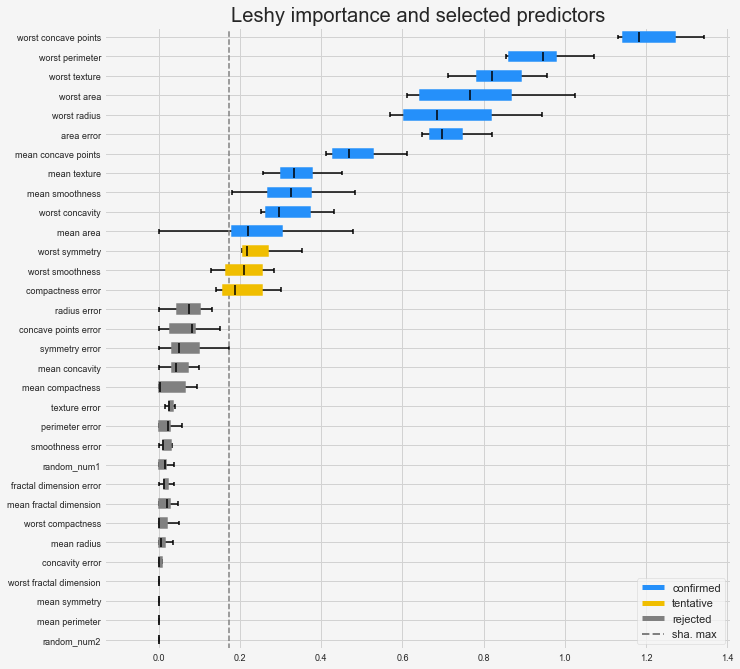

==================== Leshy - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	12
Tentative: 	4
Rejected: 	13
All relevant predictors selected in 00:00:03.19
['mean texture', 'mean area', 'mean smoothness', 'mean concave points', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst concavity', 'worst concave points']


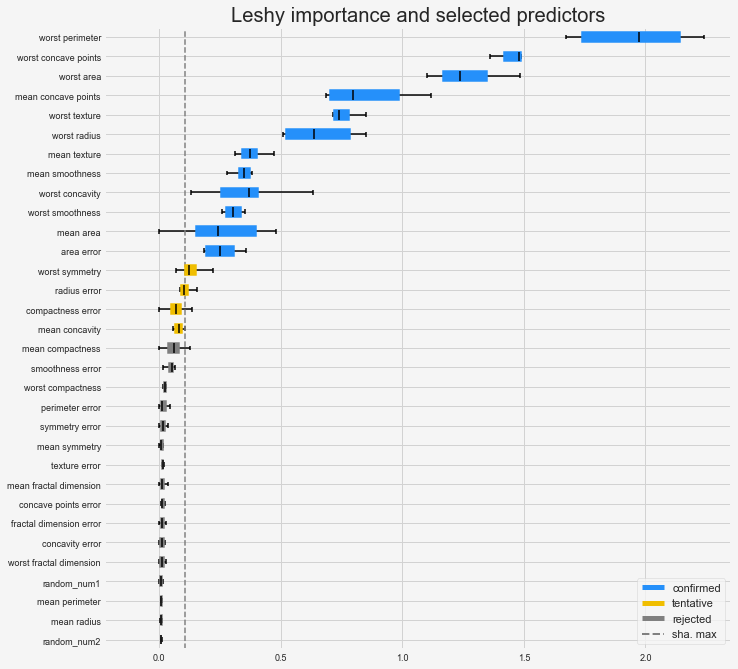

==================== Leshy - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.1767766952966369, force_col_wise=True,
               verbose=-1) for var.imp: shap            ====================
[LightGBM] [Warning] feature_fraction is set=0.1767766952966369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1767766952966369
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration: 1 / 10
[LightGBM] [Warning] feature_fraction is set=0.1767766952966369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1767766952966369
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 

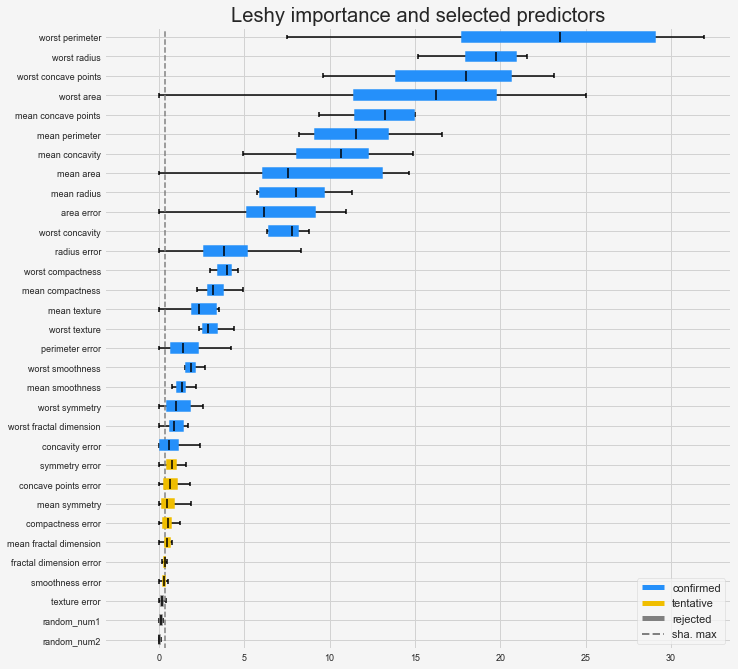

==================== Leshy - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	0
Tentative: 	4
Rejected: 	12
All relevant predictors selected in 00:00:45.88
[]


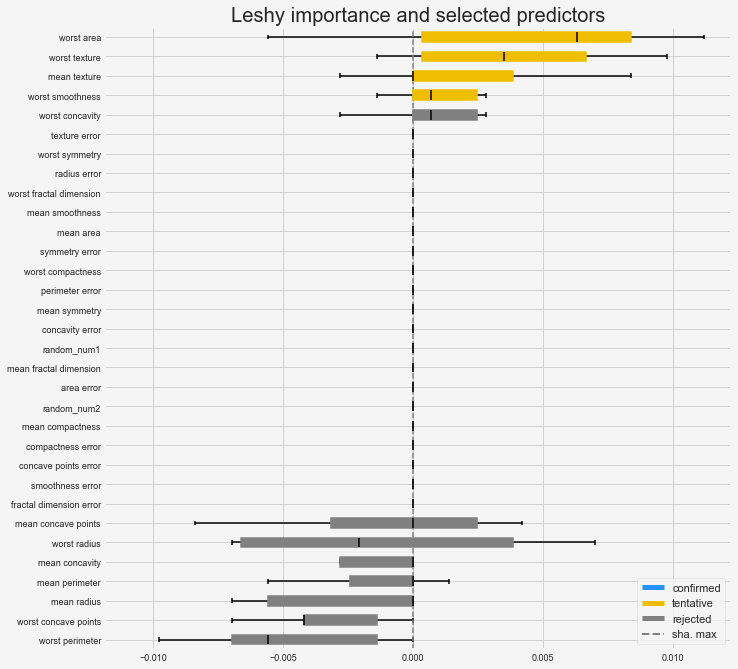

==================== Leshy - testing: <catboost.core.CatBoostClassifier object at 0x0000018F774ECD48> for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	1
Tentative: 	2
Rejected: 	17
All relevant predictors selected in 00:00:15.90
['worst texture']


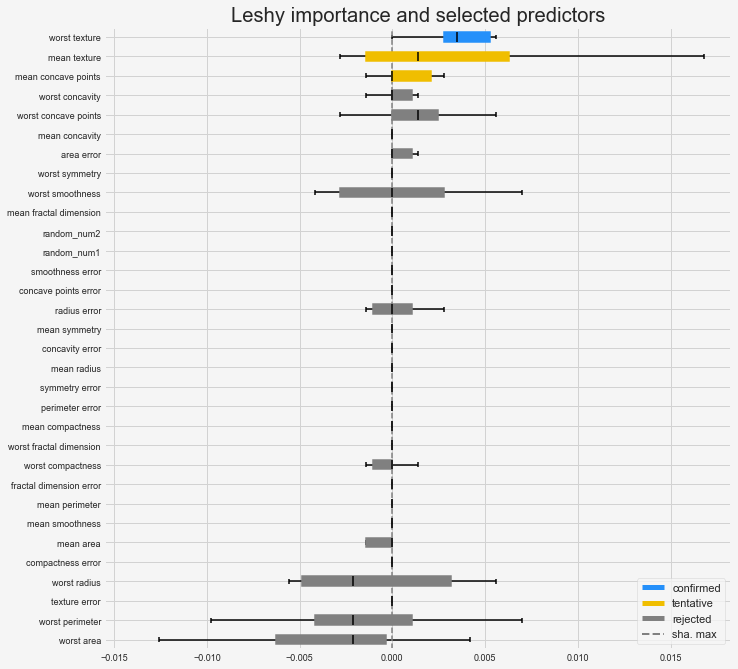

==================== Leshy - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	5
Rejected: 

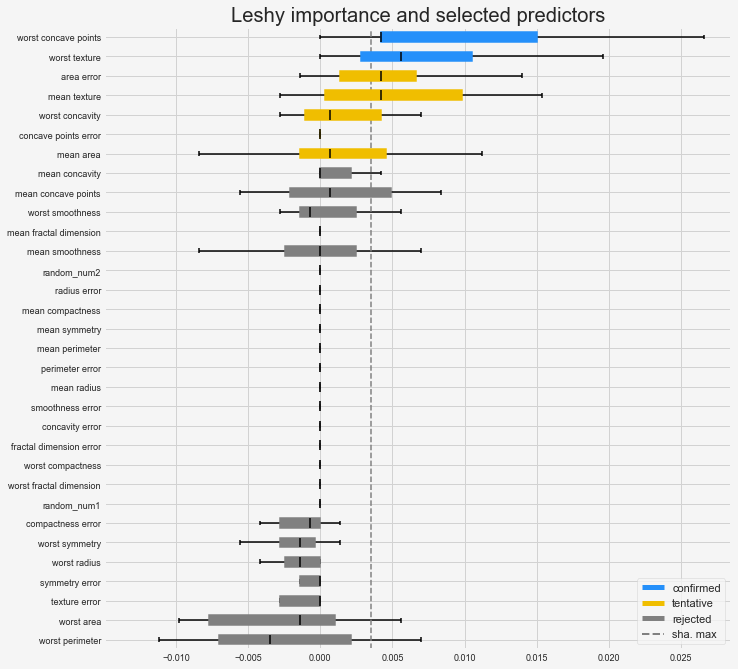

==================== Leshy - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	6
Rejected: 	14
All relevant predictors selected in 00:00:06.61
['worst texture', 'worst perimeter', 'worst concave points']


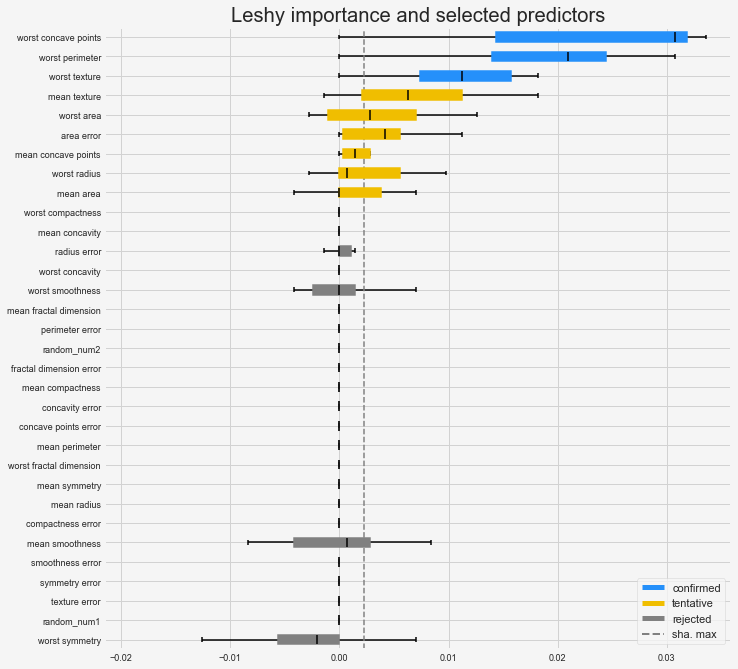

==================== Leshy - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.1767766952966369, force_col_wise=True,
               verbose=-1) for var.imp: pimp            ====================
[LightGBM] [Warning] feature_fraction is set=0.1767766952966369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1767766952966369
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration: 1 / 10
[LightGBM] [Warning] feature_fraction is set=0.1767766952966369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1767766952966369
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 

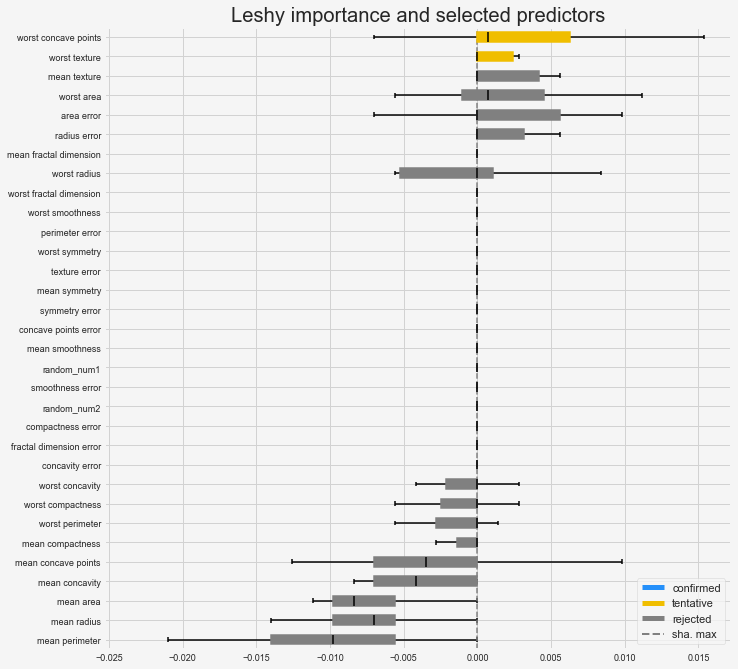

==================== Leshy - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	22
Tentative: 	8
Rejected: 	2
All relevant predictors selected in 00:00:03.39
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean compactness', 'mean concavity', 'mean concave points', 'radius error', 'perimeter error', 'area error', 'concavity error', 'concave points error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


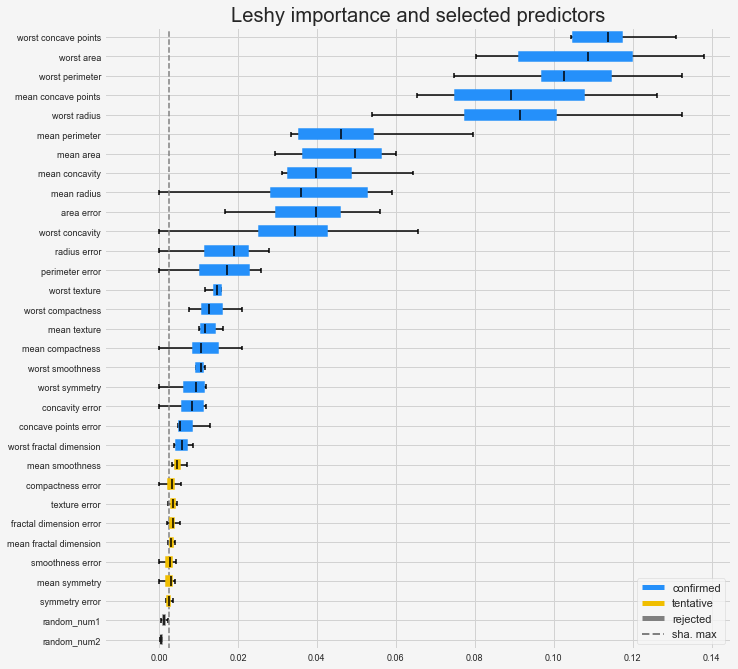

==================== Leshy - testing: <catboost.core.CatBoostClassifier object at 0x0000018F77246D48> for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	13
Tentative: 	4
Rejected: 	7
All relevant predictors selected in 00:00:07.13
['mean texture', 'mean concavity', 'mean concave points', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry']


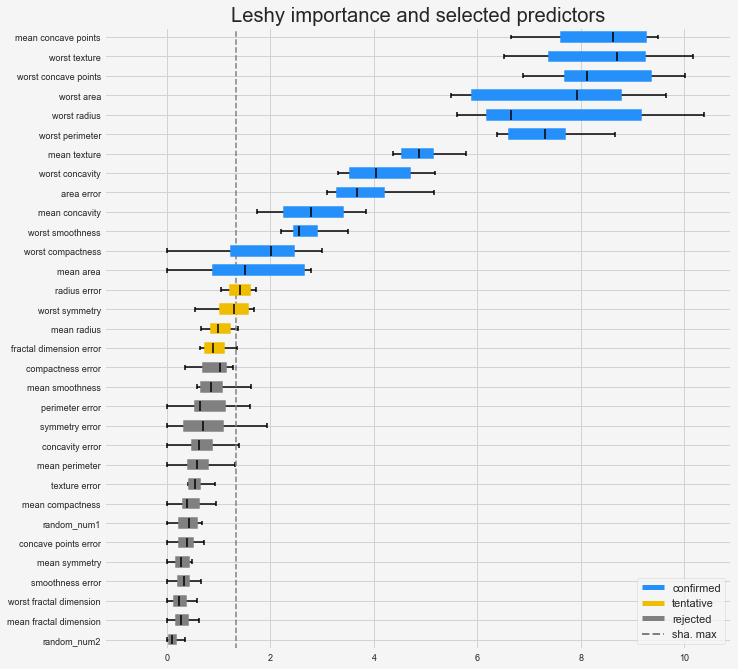

==================== Leshy - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	11
Tentative: 	2
Rejecte

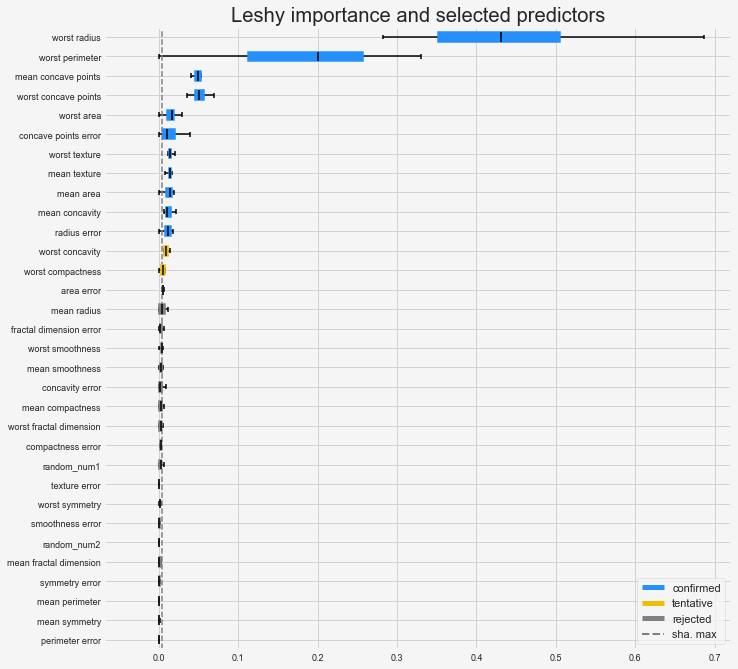

==================== Leshy - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	10
Tentative: 	4
Rejected: 	10
All relevant predictors selected in 00:00:01.22
['mean texture', 'mean concave points', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst concavity', 'worst concave points']


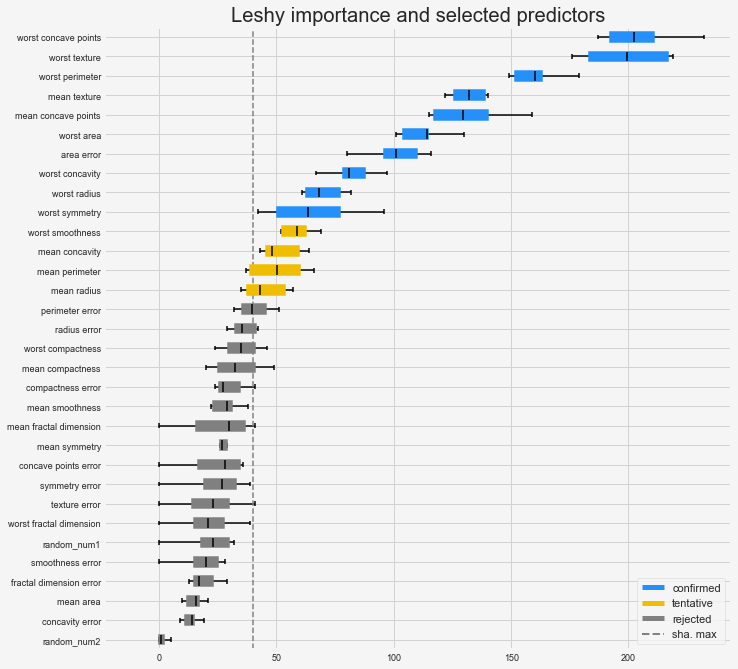

==================== Leshy - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.1767766952966369, force_col_wise=True,
               verbose=-1) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	24
Tentative: 	7
Rejected: 	0
All relevant predictors selected in 00:00:00.28
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'concavity error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst

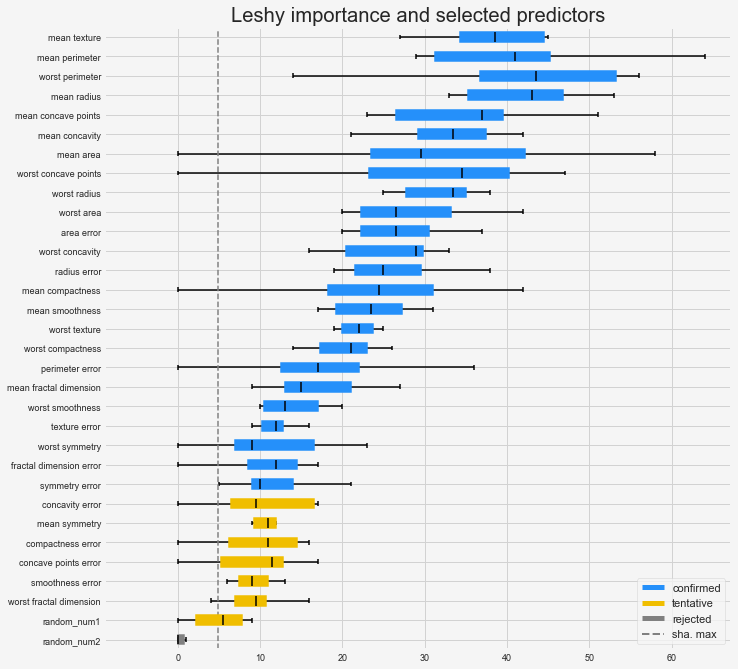

==================== Leshy - testing:         RandomForestRegressor(n_jobs=4, oob_score=True) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	10
Tentative: 	0
Rejected: 	3
All relevant predictors selected in 00:00:12.96
[0, 4, 5, 6, 7, 9, 10, 11, 12, 'random_num1']


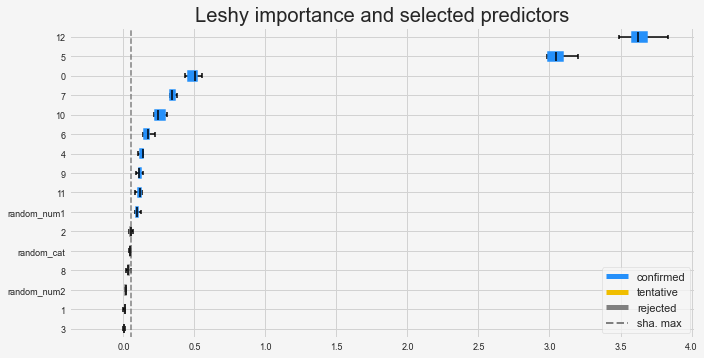

==================== Leshy - testing: <catboost.core.CatBoostRegressor object at 0x0000018F773D1C88> for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	3
Rejected: 	8
All relevant predictors selected in 00:00:07.71
[1, 4, 8]


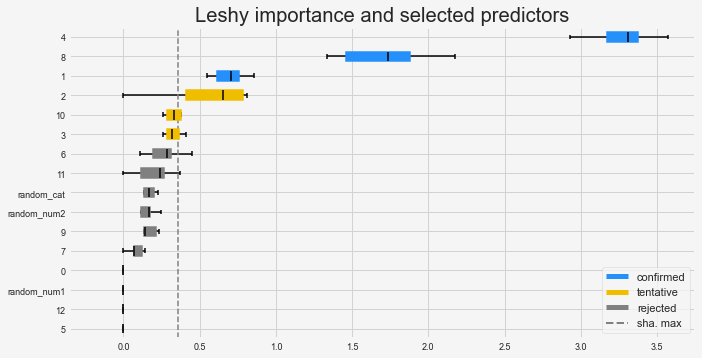

==================== Leshy - testing: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=False, verbose=0, verbosity=None) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	8
Tentative: 	4
Rejected: 	4
All re

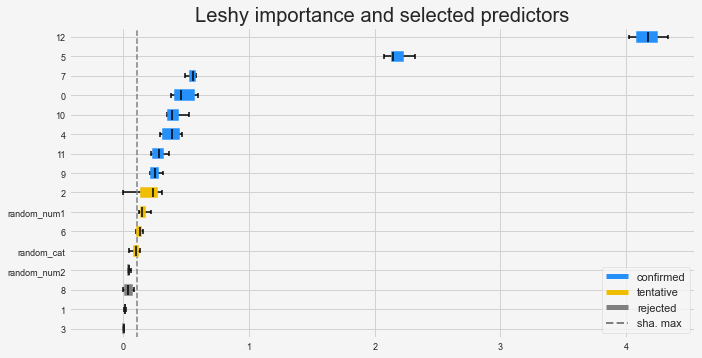

==================== Leshy - testing:              LGBMRegressor(random_state=42, verbose=-1) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:02.13
[0, 4, 5, 6, 7, 9, 10, 11, 12]


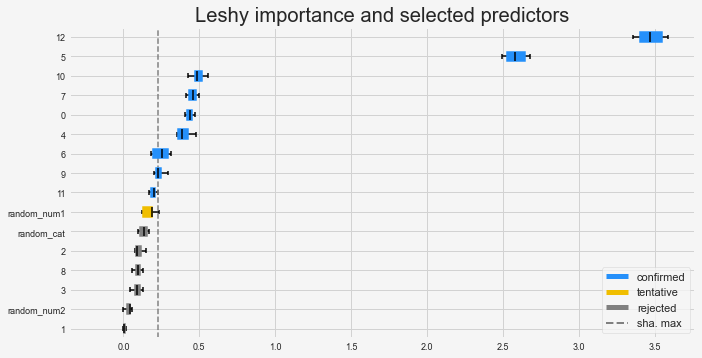

==================== Leshy - testing: LGBMRegressor(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
              feature_fraction=0.3333333333333333, force_col_wise=True,
              verbose=-1) for var.imp: shap            ====================
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration: 1 / 10
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 wil

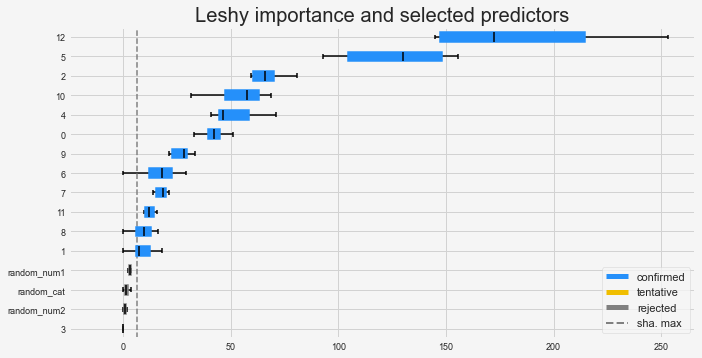

==================== Leshy - testing:         RandomForestRegressor(n_jobs=4, oob_score=True) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:29.62
[0, 4, 5, 6, 7, 9, 10, 11, 12]


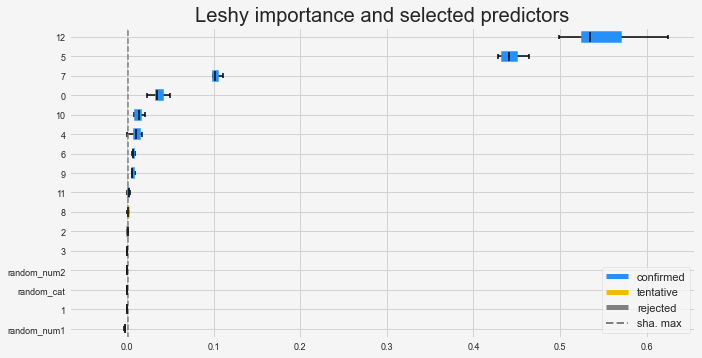

==================== Leshy - testing: <catboost.core.CatBoostRegressor object at 0x0000018F777023C8> for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	5
Rejected: 	5
All relevant predictors selected in 00:00:14.44
[1, 4]


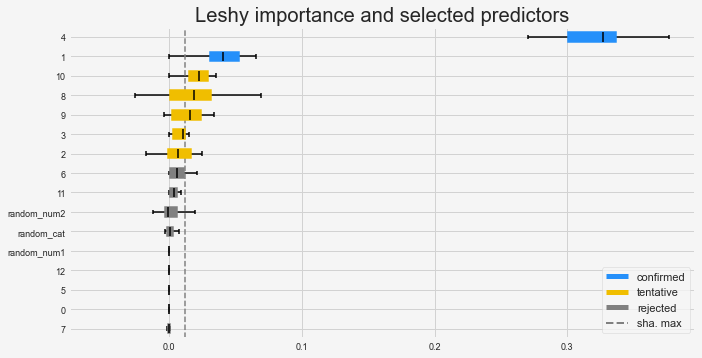

==================== Leshy - testing: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=False, verbose=0, verbosity=None) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	4
All re

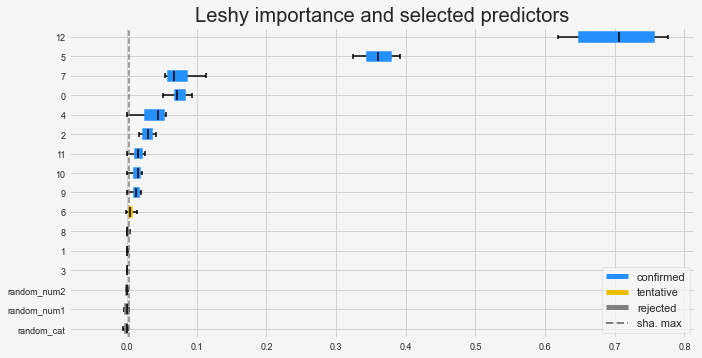

==================== Leshy - testing:              LGBMRegressor(random_state=42, verbose=-1) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	7
Tentative: 	2
Rejected: 	2
All relevant predictors selected in 00:00:03.91
[0, 4, 5, 7, 9, 10, 12]


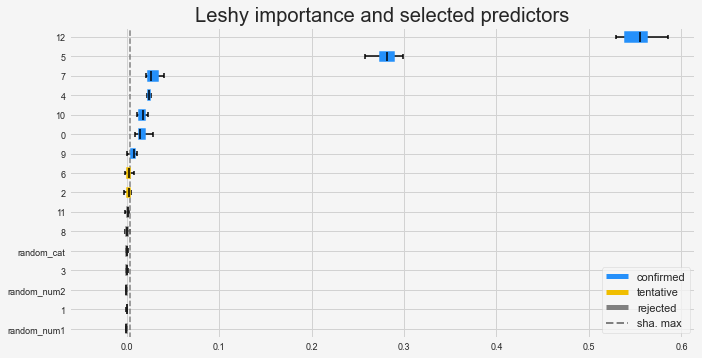

==================== Leshy - testing: LGBMRegressor(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
              feature_fraction=0.3333333333333333, force_col_wise=True,
              verbose=-1) for var.imp: pimp            ====================
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration: 1 / 10
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 wil

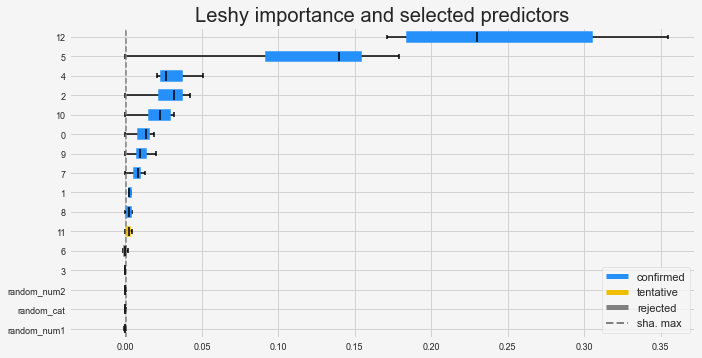

==================== Leshy - testing:         RandomForestRegressor(n_jobs=4, oob_score=True) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	6
All relevant predictors selected in 00:00:04.25
[0, 4, 5, 6, 7, 9, 10, 11, 12]


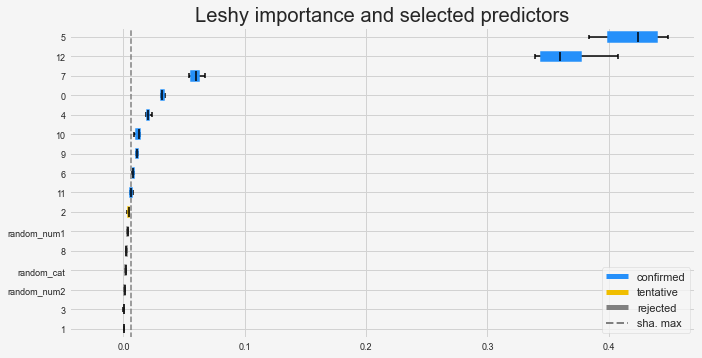

==================== Leshy - testing: <catboost.core.CatBoostRegressor object at 0x0000018F77272108> for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	4
Tentative: 	2
Rejected: 	8
All relevant predictors selected in 00:00:07.16
[1, 2, 4, 8]


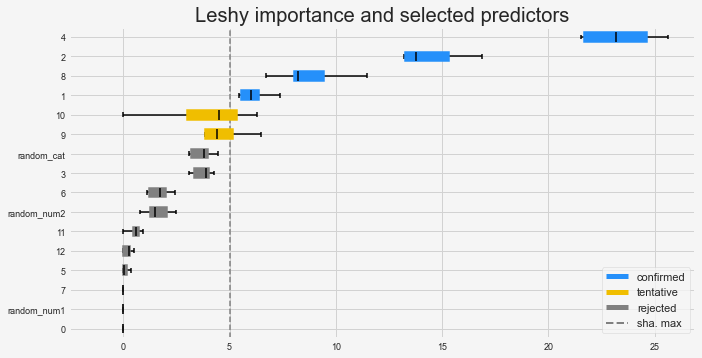

==================== Leshy - testing: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=False, verbose=0, verbosity=None) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	2
All 

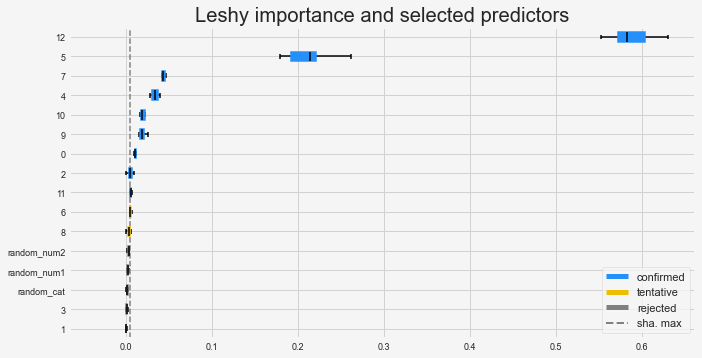

==================== Leshy - testing:              LGBMRegressor(random_state=42, verbose=-1) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	6
Tentative: 	1
Rejected: 	6
All relevant predictors selected in 00:00:00.50
[0, 4, 5, 6, 7, 12]


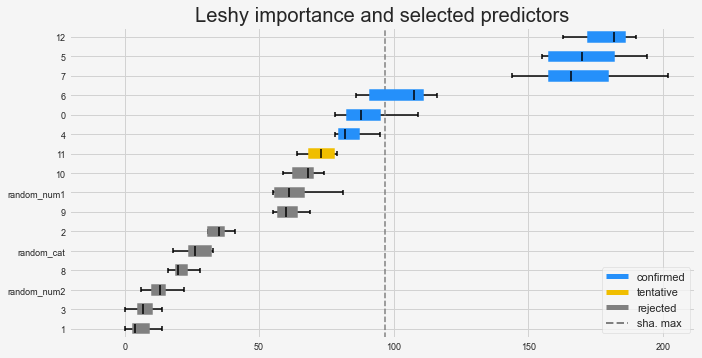

==================== Leshy - testing: LGBMRegressor(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
              feature_fraction=0.3333333333333333, force_col_wise=True,
              verbose=-1) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	10
Tentative: 	1
Rejected: 	4
All relevant predictors selected in 00:00:00.24
[0, 2, 4, 5, 6, 7, 9, 10, 11, 12]


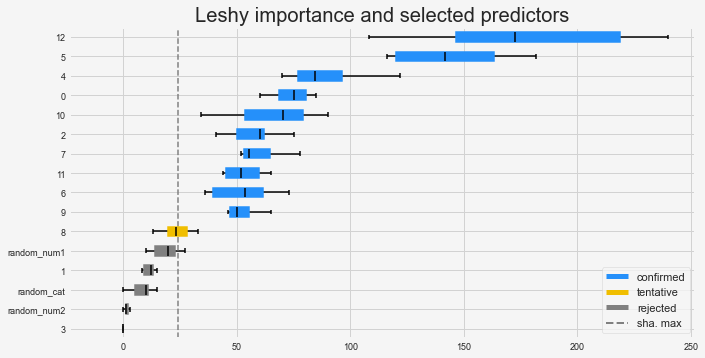

In [6]:
%matplotlib inline
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
import catboost
from boruta import BorutaPy as bp
from sklearn.datasets import load_boston, load_diabetes, load_breast_cancer
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import shap
# lightgbm and catboost
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sys import getsizeof, path
plt.style.use('fivethirtyeight')
rng = np.random.RandomState(seed=42)

import warnings
warnings.filterwarnings('ignore')

# Convert the cat. pred. for boosting
def cat_var(df, col_excl=None, return_cat=True):
    """Identify categorical features.

        Parameters
        ----------
        df: original df after missing operations

        Returns
        -------
        cat_var_df: summary df with col index and col name for all categorical vars
        :param return_cat: Boolean, return encoded cols as type 'category'
        :param df: pd.DF, the encoded data-frame
        :param col_excl: list, colums not to be encoded
        """

    if col_excl is None:
        non_num_cols = list(set(list(df.columns)) - set(list(df.select_dtypes(include=[np.number]))))
    else:
        non_num_cols = list(
            set(list(df.columns)) - set(list(df.select_dtypes(include=[np.number]))) - set(col_excl))

    # cat_var_index = [i for i, x in enumerate(df[col_names].dtypes.tolist()) if isinstance(x, pd.CategoricalDtype) or x == 'object']
    # cat_var_name = [x for i, x in enumerate(col_names) if i in cat_var_index]

    cat_var_index = [df.columns.get_loc(c) for c in non_num_cols if c in df]

    cat_var_df = pd.DataFrame({'cat_ind': cat_var_index,
                               'cat_name': non_num_cols})

    cols_need_mapped = cat_var_df.cat_name.to_list()
    inv_mapper = {col: dict(enumerate(df[col].astype('category').cat.categories)) for col in df[cols_need_mapped]}
    mapper = {col: {v: k for k, v in inv_mapper[col].items()} for col in df[cols_need_mapped]}

    for c in cols_need_mapped:
        df.loc[:, c] = df.loc[:, c].map(mapper[c]).fillna(0).astype(int)

    if return_cat:
        df[non_num_cols] = df[non_num_cols].astype('category')
    return df, cat_var_df, inv_mapper


def get_titanic_data():
    # Fetch Titanic data and add random cat and numbers
    # Example taken from https://scikit-learn.org/stable/auto_examples/inspection/
    # plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
    X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
    rng = np.random.RandomState(seed=42)
    X['random_cat'] = rng.randint(3, size=X.shape[0])
    X['random_cat'] = X['random_cat'].astype('str')
    X['random_num'] = rng.randn(X.shape[0])

    categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
    numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']
    X = X[categorical_columns + numerical_columns]
    # Impute
    categorical_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing'))])
    numerical_pipe = Pipeline([('imputer', SimpleImputer(strategy='mean'))])
    preprocessing = ColumnTransformer([('cat', categorical_pipe, categorical_columns), ('num', numerical_pipe, numerical_columns)])
    X_trans = preprocessing.fit_transform(X)
    X = pd.DataFrame(X_trans, columns = X.columns)
    # encode
    X, cat_var_df, inv_mapper = cat_var(X)
    # sample weight is just a dummy random vector for testing purpose
    sample_weight = np.random.uniform(0,1, len(y))
    return X, y, sample_weight


def get_cancer_data():
    data = load_breast_cancer()
    X, y = data.data, data.target
    X = pd.DataFrame(X)
    X.columns = data.feature_names
    X['random_num1'] = rng.randn(X.shape[0])
    X['random_num2'] = np.random.poisson(1, X.shape[0])
    y = pd.Series(y)
    return X, y

def get_boston_data():
    boston = load_boston()
    rng = np.random.RandomState(seed=42)
    X = pd.DataFrame(boston.data)
    X['random_num1'] = rng.randn(X.shape[0])
    X['random_num2'] = np.random.poisson(1, X.shape[0])
    X['random_cat'] = rng.randint(10, size=X.shape[0])
    X['random_cat'] = X['random_cat'].astype('str')
    y = pd.Series(boston.target)
    return X, y


# lightGBM implementation of random forest
# Optimal feature fraction as given by Breiman
def LightForestClassifier(n_feat):
    return lgb.LGBMClassifier(verbose=-1, force_col_wise=True, n_estimators=100, bagging_fraction=0.632,
                                   feature_fraction=np.sqrt(n_feat) / n_feat, boosting_type="rf", bagging_freq=1)

def LightForestRegressor(n_feat):
    return lgb.LGBMRegressor(verbose=-1, force_col_wise=True, n_estimators=100, bagging_fraction=0.632,
                                   feature_fraction=n_feat / (3*n_feat), boosting_type="rf", bagging_freq=1)

# Testing the changes with rnd cat. and num. predictors added to the set of genuine predictors
def testing_estimators(varimp, models, X, y, sample_weight=None):
    for model in models:
        print('='*20 +' Leshy - testing: {mod:>55} for var.imp: {vimp:<15} '.format(mod=str(model), vimp=varimp)+'='*20 )
        feat_selector = arfsgroot.Leshy(model, n_estimators = 100, verbose= 1, max_iter= 10, random_state=42, importance=varimp)
        feat_selector.fit(X, y, sample_weight)
        print(feat_selector.support_names_)
        feat_selector.plot_importance(n_feat_per_inch=3)
        gc.enable()
        del(feat_selector, model)
        gc.collect()

def testing_clf_all_varimp(X, y, sample_weight=None):
    for varimp in ['shap', 'pimp', 'native']:
        models = [RandomForestClassifier(n_jobs= 4, oob_score= True), 
                  catboost.CatBoostClassifier(random_state=42, verbose=0), 
                  XGBClassifier(random_state=42, verbose=0), 
                  LGBMClassifier(random_state=42, verbose=-1),
                  LightForestClassifier(n_feat=X.shape[1])]
        testing_estimators(varimp=varimp, models=models, X=X, y=y, sample_weight=sample_weight)
        gc.enable()
        del(models)
        gc.collect()

def testing_regr_all_varimp(X, y, sample_weight=None):
    for varimp in ['shap', 'pimp', 'native']:
        models = [RandomForestRegressor(n_jobs= 4, oob_score= True), 
                  catboost.CatBoostRegressor(random_state=42, verbose=0), 
                  XGBRegressor(random_state=42, verbose=0), 
                  LGBMRegressor(random_state=42, verbose=-1),
                  LightForestRegressor(n_feat=X.shape[1])]
        testing_estimators(varimp=varimp, models=models, X=X, y=y)
        gc.enable()
        del(models)
        gc.collect()
        

print('='*20 + ' Benchmarking using sklearn permutation importance ' + '='*20 )
X, y, sample_weight = get_titanic_data()
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, sample_weight, stratify=y, random_state=42)
# lightgbm faster and better than RF
lgb_model = LGBMClassifier(n_jobs= 4)
lgb_model.fit(X_train, y_train, sample_weight=w_train)
result = permutation_importance(lgb_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
# Plot
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()


if __name__ == '__main__':
    # classification and cat. pred, sample weight is just a dummy random vector for testing purpose
    X, y, sample_weight = get_titanic_data() #get_titanic_data()
    testing_clf_all_varimp(X=X, y=y, sample_weight=sample_weight)
     # classification and cat. pred
    X, y = get_cancer_data() #get_titanic_data()
    testing_clf_all_varimp(X=X, y=y)
    # regression
    X, y = get_boston_data()
    testing_regr_all_varimp(X=X, y=y)

# Testing GrootCV

BoostaGroota: classification with unbalance classes
Groot iteration:  0  with 5 folds
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Groot iteration:  1  with 5 folds
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightG

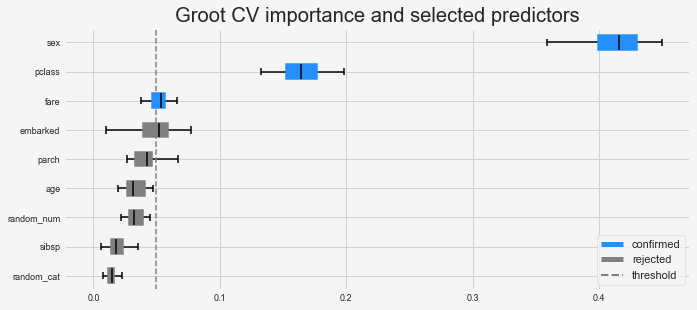

BoostaGroota: classification with unbalance classes
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Groot iteration:  0  with 5 folds
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Groot iteration:  1  with 5 folds
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightG

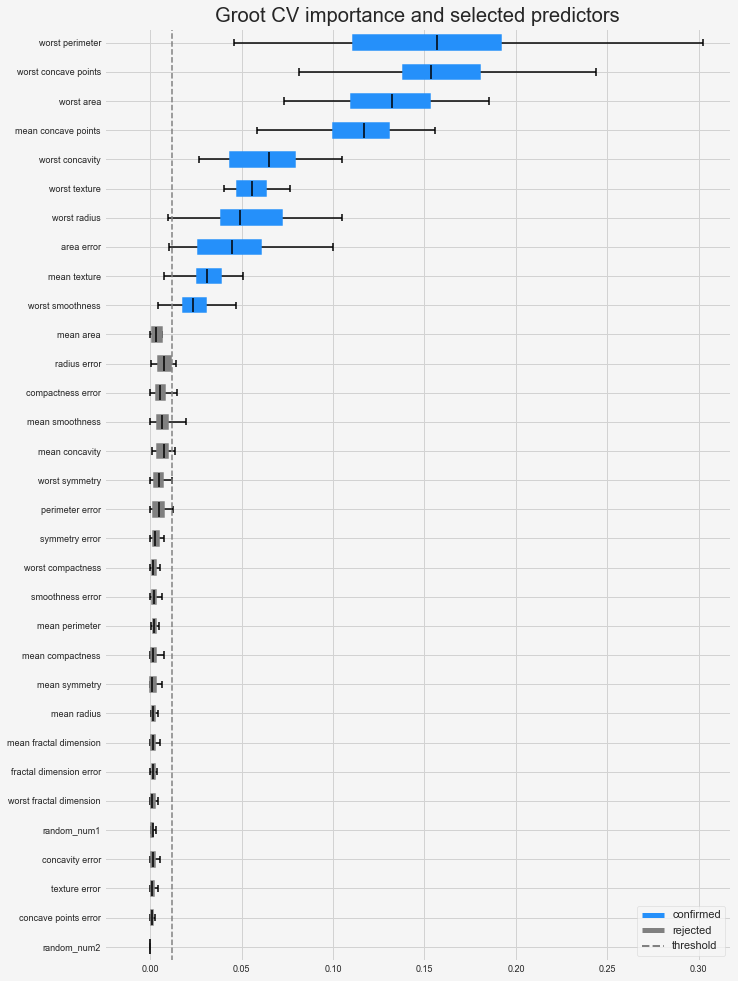

[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Groot iteration:  0  with 5 folds
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Groot iteration:  1  with 5 folds
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be

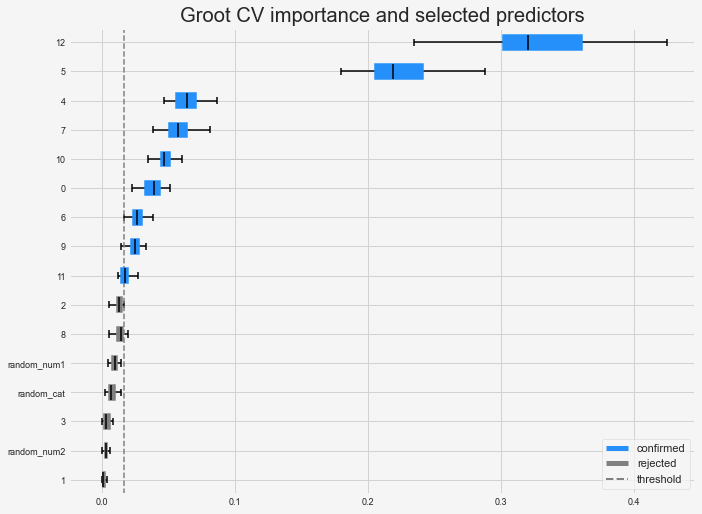

In [7]:
# Testing the changes with rnd cat. and num. predictors added to the set of genuine predictors
def testing_estimators(X, y, sample_weight=None, objective='rmse'):
    feat_selector = arfsgroot.GrootCV(objective=objective, cutoff = 1, n_folds=5, n_iter=5, silent=False)
    feat_selector.fit(X, y, sample_weight)
    print(feat_selector.keep_vars_ )
    feat_selector.plot_importance(n_feat_per_inch=2)
    gc.enable()
    del(feat_selector)
    gc.collect()
        

if __name__ == '__main__':
    # classification and cat. pred, sample weight is just a dummy random vector for testing purpose
    X, y, sample_weight = get_titanic_data() #get_cancer_data():
    testing_estimators(X=X, y=y, sample_weight=sample_weight, objective='binary')
    
    # classification and cat. pred
    X, y = get_cancer_data() #get_cancer_data():
    testing_estimators(X=X, y=y, objective='binary')
    
    # regression
    X, y = get_boston_data()
    testing_estimators(X=X, y=y, objective='rmse')

# Testing BoostAGroota

==================== BoostAGroota - testing:             RandomForestClassifier(n_jobs=4, oob_score=True) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.

The feature selection BoostARoota running time is     1.12 min
0      pclass
1         sex
2    embarked
3       parch
4        fare
Name: feature, dtype: object


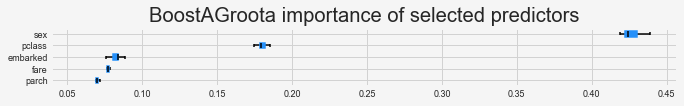

==================== BoostAGroota - testing: <catboost.core.CatBoostClassifier object at 0x0000018F774E3E48> ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.

The feature selection BoostARoota running time is     2.07 min
0      pclass
1         sex
2    embarked
3       parch
Name: feature, dtype: object


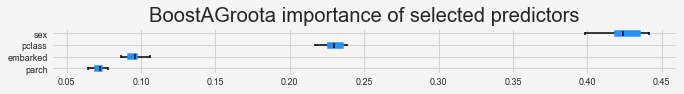

==================== BoostAGroota - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  itera

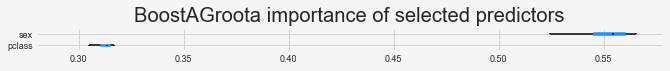

==================== BoostAGroota - testing:                  LGBMClassifier(random_state=42, verbose=-1) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.

The feature selection BoostARoota running time is     0.37 min
0    pclass
1       sex
Name: feature, dtype: object


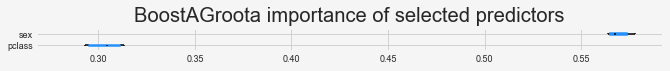

==================== BoostAGroota - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.3333333333333333, force_col_wise=True,
               verbose=-1) ====================
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Round:  1  iteration:  1
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

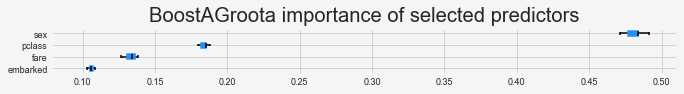

==================== BoostAGroota - testing:             RandomForestClassifier(n_jobs=4, oob_score=True) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.

The feature selection BoostARoota running time is     0.17 min
0                 mean radius
1                mean texture
2              mean perimeter
3                   mean area
4             mean smoothness
5            mean compactness
6              mean concavity
7         mean concave points
8 

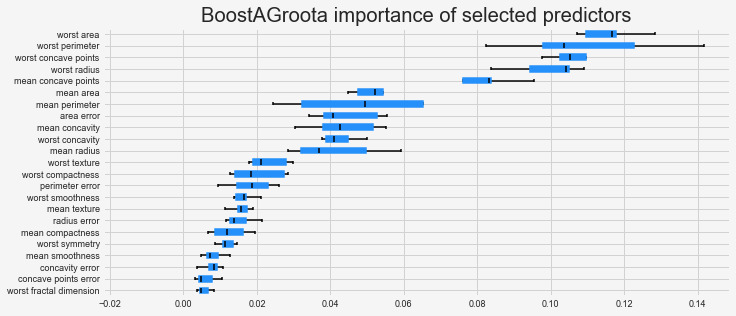

==================== BoostAGroota - testing: <catboost.core.CatBoostClassifier object at 0x0000018F6CE96C08> ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
Round:  3  iteration:  1
Round:  3  iteration:  2
Round:  3  iteration:  3
Round:  3  iteration:  4
Round:  3  iteration:  5
Round:  3  iteration:  6
Round:  3  iteration:  7
Round:  3  iteration:  8
Round:  3  iteration:  9
Round:  3  iteration:  10
BoostARoota ran successfully! Algorithm went through  3  rounds.

The feature selection BoostARoota running time is  

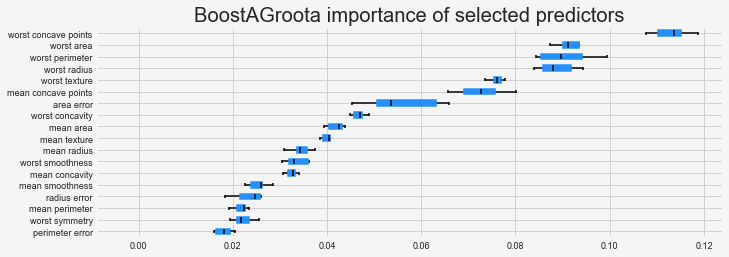

==================== BoostAGroota - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  itera

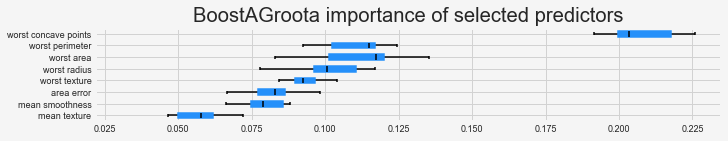

==================== BoostAGroota - testing:                  LGBMClassifier(random_state=42, verbose=-1) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.

The feature selection BoostARoota running time is     0.11 min
0             mean texture
1                mean area
2          mean smoothness
3      mean concave points
4               area error
5             worst radius
6            worst texture
7          worst perimeter
8               worst area

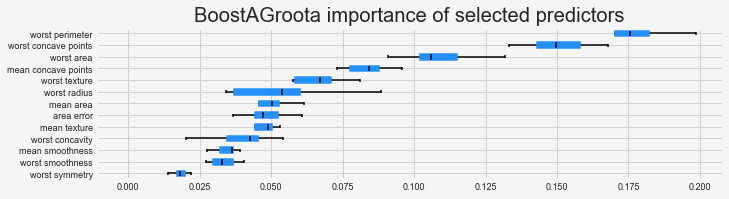

==================== BoostAGroota - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.1767766952966369, force_col_wise=True,
               verbose=-1) ====================
[LightGBM] [Warning] feature_fraction is set=0.1767766952966369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1767766952966369
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Round:  1  iteration:  1
[LightGBM] [Warning] feature_fraction is set=0.1767766952966369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1767766952966369
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

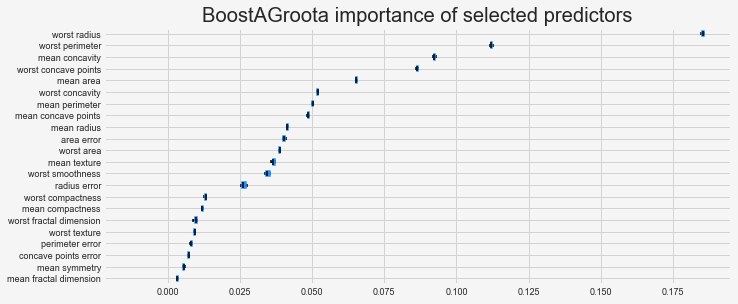

==================== BoostAGroota - testing:              RandomForestRegressor(n_jobs=4, oob_score=True) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.

The feature selection BoostARoota running time is     0.48 min
0              0
1              4
2              5
3              6
4              7
5              9
6             10
7             11
8             12
9    random_num1
Name: feature, dtype: object


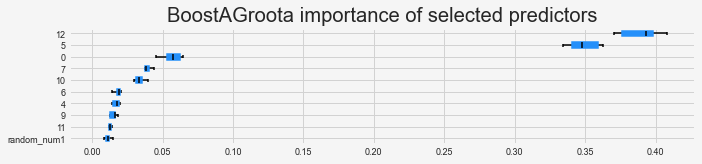

==================== BoostAGroota - testing: <catboost.core.CatBoostRegressor object at 0x0000018F773ED608> ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.

The feature selection BoostARoota running time is     1.03 min
0     0
1     2
2     4
3     5
4     6
5     7
6     9
7    10
8    11
9    12
Name: feature, dtype: object


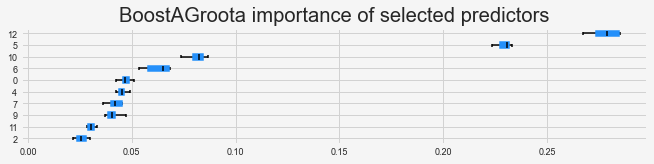

==================== BoostAGroota - testing: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=False, verbose=0, verbosity=None) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2


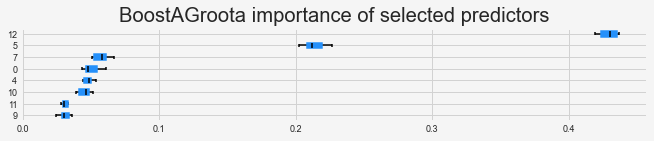

==================== BoostAGroota - testing:                   LGBMRegressor(random_state=42, verbose=-1) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
Round:  3  iteration:  1
Round:  3  iteration:  2
Round:  3  iteration:  3
Round:  3  iteration:  4
Round:  3  iteration:  5
Round:  3  iteration:  6
Round:  3  iteration:  7
Round:  3  iteration:  8
Round:  3  iteration:  9
Round:  3  iteration:  10
Round:  4  iteration:  1
Round:  4  iteration:  2
Round:  4  iteration:  3
Round:  4  iteration:  4
Round:  4  iteration

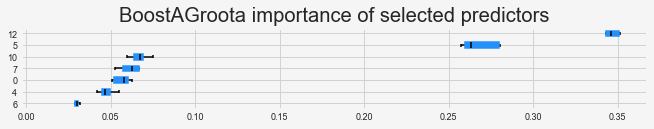

==================== BoostAGroota - testing: LGBMRegressor(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
              feature_fraction=0.3333333333333333, force_col_wise=True,
              verbose=-1) ====================
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Round:  1  iteration:  1
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. C

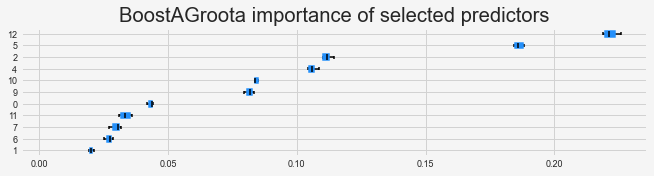

In [8]:
# Testing the changes with rnd cat. and num. predictors added to the set of genuine predictors
def testing_estimators(models, X, y, sample_weight=None):
    for model in models:
        print('='*20 + ' BoostAGroota - testing: {mod:>60} '.format(mod=str(model)) +'='*20 )
        feat_selector = arfsgroot.BoostAGroota(est=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, silent=False, imp='shap')
        feat_selector.fit(X, y)
        print(feat_selector.keep_vars_ )
        feat_selector.plot_importance()
        gc.enable()
        del(feat_selector, model)
        gc.collect()

def testing_clf_all_varimp(X, y, sample_weight=None):
    models = [RandomForestClassifier(n_jobs= 4, oob_score= True), 
              catboost.CatBoostClassifier(random_state=42, verbose=0), 
              XGBClassifier(random_state=42, verbose=0), 
              LGBMClassifier(random_state=42, verbose=-1),
              LightForestClassifier(n_feat=X.shape[1])]
    testing_estimators(models=models, X=X, y=y, sample_weight=sample_weight)
    gc.enable()
    del(models)
    gc.collect()

def testing_regr_all_varimp(X, y):
    models = [RandomForestRegressor(n_jobs= 4, oob_score= True), 
              catboost.CatBoostRegressor(random_state=42, verbose=0), 
              XGBRegressor(random_state=42, verbose=0), 
              LGBMRegressor(random_state=42, verbose=-1),
              LightForestRegressor(n_feat=X.shape[1])]
    testing_estimators(models=models, X=X, y=y)
    gc.enable()
    del(models)
    gc.collect()
        
if __name__ == '__main__':
    # classification and cat. pred, sample weight is just a dummy random vector for testing purpose
    X, y, sample_weight= get_titanic_data()
    testing_clf_all_varimp(X=X, y=y, sample_weight=sample_weight)
    # classification and cat. pred
    X, y = get_cancer_data()
    testing_clf_all_varimp(X=X, y=y)
    # regression
    X, y = get_boston_data()
    testing_regr_all_varimp(X=X, y=y)